# EDA

Flight Delay Prediction Challenge.
Predict airline delays for Tunisian aviation company, Tunisair.

Hypotheses:
1) Flights departing from certain airports experience longer delays than others.
2) Morning flights have fewer delays than evening flights.
3) Certain aircraft types have higher delays due to mainteance or operational issues.
4) Delays are higher during peak travel season?


## Load packages

In [111]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedStratifiedKFold

## Load and explore data

Column definitions

DATOP - Date of flight <br>
FLTID - Flight number <br>
DEPSTN - Departure point <br>
ARRSTN - Arrival point <br>
STD - Scheduled Time departure <br>
STA - Scheduled Time arrival <br>
STATUS - Flight status <br>
AC - Aircraft Code <br>
Target - Delay in minutes <br>

In [112]:
df = pd.read_csv("data/RawData.csv")
df

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17.00.00,ATA,TU 736IOK,0.0
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15.50.00,ATA,TU 320IMU,22.0
...,...,...,...,...,...,...,...,...,...,...
107828,train_id_107828,2018-07-05,WKL 0000,TUN,TUN,2018-07-05 23:00:00,2018-07-06 02.00.00,SCH,TU 32AIML,0.0
107829,train_id_107829,2018-01-13,UG 0003,DJE,TUN,2018-01-13 08:00:00,2018-01-13 09.00.00,SCH,UG AT7AT7,0.0
107830,train_id_107830,2018-11-07,SGT 0000,TUN,TUN,2018-11-07 05:00:00,2018-11-07 12.50.00,SCH,TU 736IOK,0.0
107831,train_id_107831,2018-01-23,UG 0010,TUN,DJE,2018-01-23 18:00:00,2018-01-23 18.45.00,ATA,TU CR9ISA,0.0


In [113]:
print("shape", df.shape)
print(df.info())

shape (107833, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107833 entries, 0 to 107832
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      107833 non-null  object 
 1   DATOP   107833 non-null  object 
 2   FLTID   107833 non-null  object 
 3   DEPSTN  107833 non-null  object 
 4   ARRSTN  107833 non-null  object 
 5   STD     107833 non-null  object 
 6   STA     107833 non-null  object 
 7   STATUS  107833 non-null  object 
 8   AC      107833 non-null  object 
 9   target  107833 non-null  float64
dtypes: float64(1), object(9)
memory usage: 8.2+ MB
None


In [114]:
# Convert columns
df["DATOP"] = pd.to_datetime(df["DATOP"])
df["STD"] = pd.to_datetime(df["STD"])
df["STA"] = pd.to_datetime(df["STA"], format='%Y-%m-%d %H.%M.%S')

# Add columns
df["FlightYear"] = df["DATOP"].dt.year
df["Departure_Month"] = df["STD"].dt.month
df["Departure_Day"] = df["STD"].dt.day
df["Departure_Weekday"] = df["STD"].dt.weekday

df["Departure_Hour"] = df["STD"].dt.hour
df["Departure_Minute"] = df["STD"].dt.minute

# Classifying into morning (4-12), afternoon (12-17), evening (18-23) and night (0-4)
df['Departure_Time_Of_Day'] = pd.cut(df['Departure_Hour'], bins=[0, 6, 12, 18, 24], labels=['night', 'morning', 'afternoon', 'evening'], right=False)

# Calculating flight duration
df['Flight_Duration'] = (((df['STA'] - df['STD']).dt.total_seconds()) / 60).astype(int)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107833 entries, 0 to 107832
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   ID                     107833 non-null  object        
 1   DATOP                  107833 non-null  datetime64[ns]
 2   FLTID                  107833 non-null  object        
 3   DEPSTN                 107833 non-null  object        
 4   ARRSTN                 107833 non-null  object        
 5   STD                    107833 non-null  datetime64[ns]
 6   STA                    107833 non-null  datetime64[ns]
 7   STATUS                 107833 non-null  object        
 8   AC                     107833 non-null  object        
 9   target                 107833 non-null  float64       
 10  FlightYear             107833 non-null  int32         
 11  Departure_Month        107833 non-null  int32         
 12  Departure_Day          107833 non-null  int3

In [115]:
# Drop rows where STATUS is "RTR" (returned to origin), "DEL" (cancelled) or "SCH"(still in the air), because aircraft never arrived at destination
df = df[~df["STATUS"].isin(["RTR", "DEL", "SCH"])]
df["STATUS"].unique()

# Drop column "STATUS" because it is not informative
df =df.drop(columns=["STATUS"])

In [116]:
# Check missing values --> no missing values
print(df.isnull().sum())

ID                       0
DATOP                    0
FLTID                    0
DEPSTN                   0
ARRSTN                   0
STD                      0
STA                      0
AC                       0
target                   0
FlightYear               0
Departure_Month          0
Departure_Day            0
Departure_Weekday        0
Departure_Hour           0
Departure_Minute         0
Departure_Time_Of_Day    0
Flight_Duration          0
dtype: int64


In [117]:
# Checking for duplicates

def check_duplicates(data):
    has_dup = data.duplicated()
    true_dup = np.where(has_dup == True)
    if len(true_dup[0]) > 0:
        print("Data has", len(true_dup[0]), "duplicates")
    else:
        print("No duplicates found")

check_duplicates(df)

No duplicates found


<Axes: >

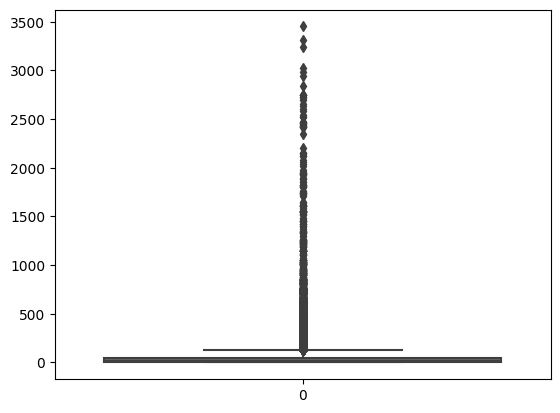

In [118]:
# Boxplot of target variable
sns.boxplot(df["target"])

In [119]:
# Columns of interest
interest = df.columns.drop(["ID", "DATOP", "STD", "STA"])

IndexError: index 4 is out of bounds for axis 0 with size 4

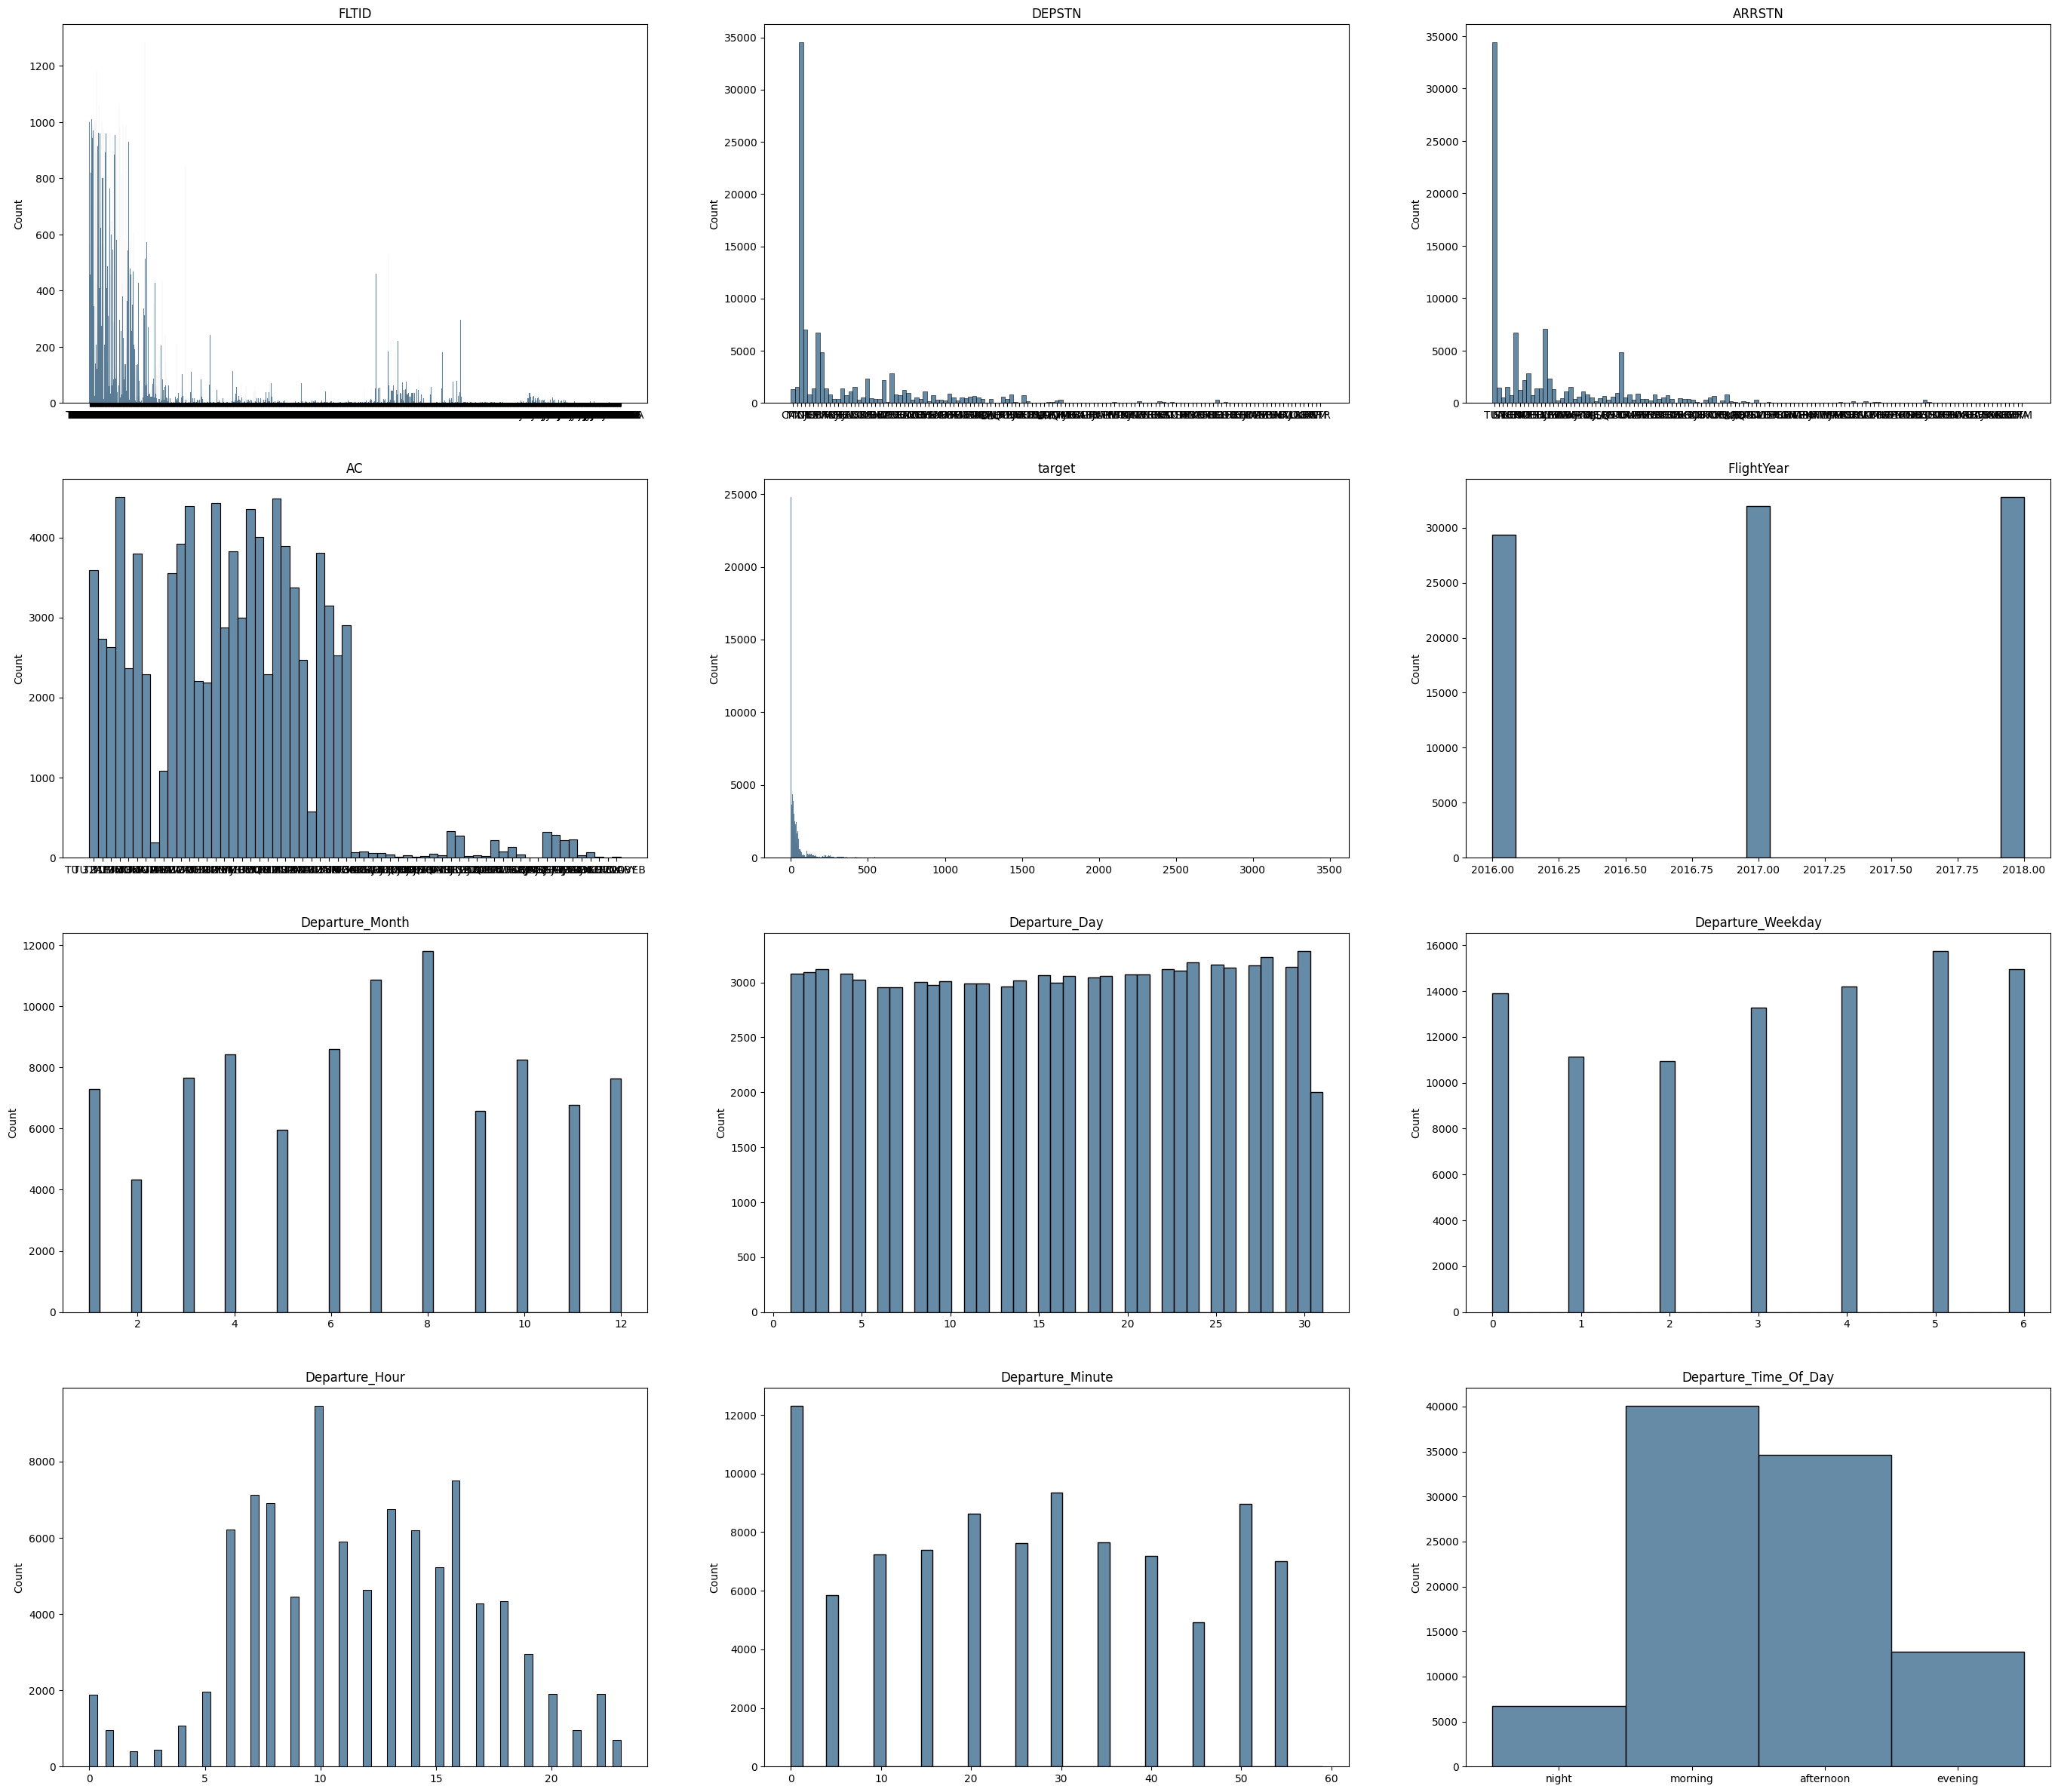

In [120]:
# Plot distribution of features 

fig,ax = plt.subplots(4,3,figsize=(34,30))
count = 0
for item in interest:
    sns.histplot(df[item], ax=ax[int(count/3)][count%3], color='#33658A').set(title=item, xlabel='')
    count += 1
ax.flat[-1].set_visible(False)
fig.tight_layout(pad=3)

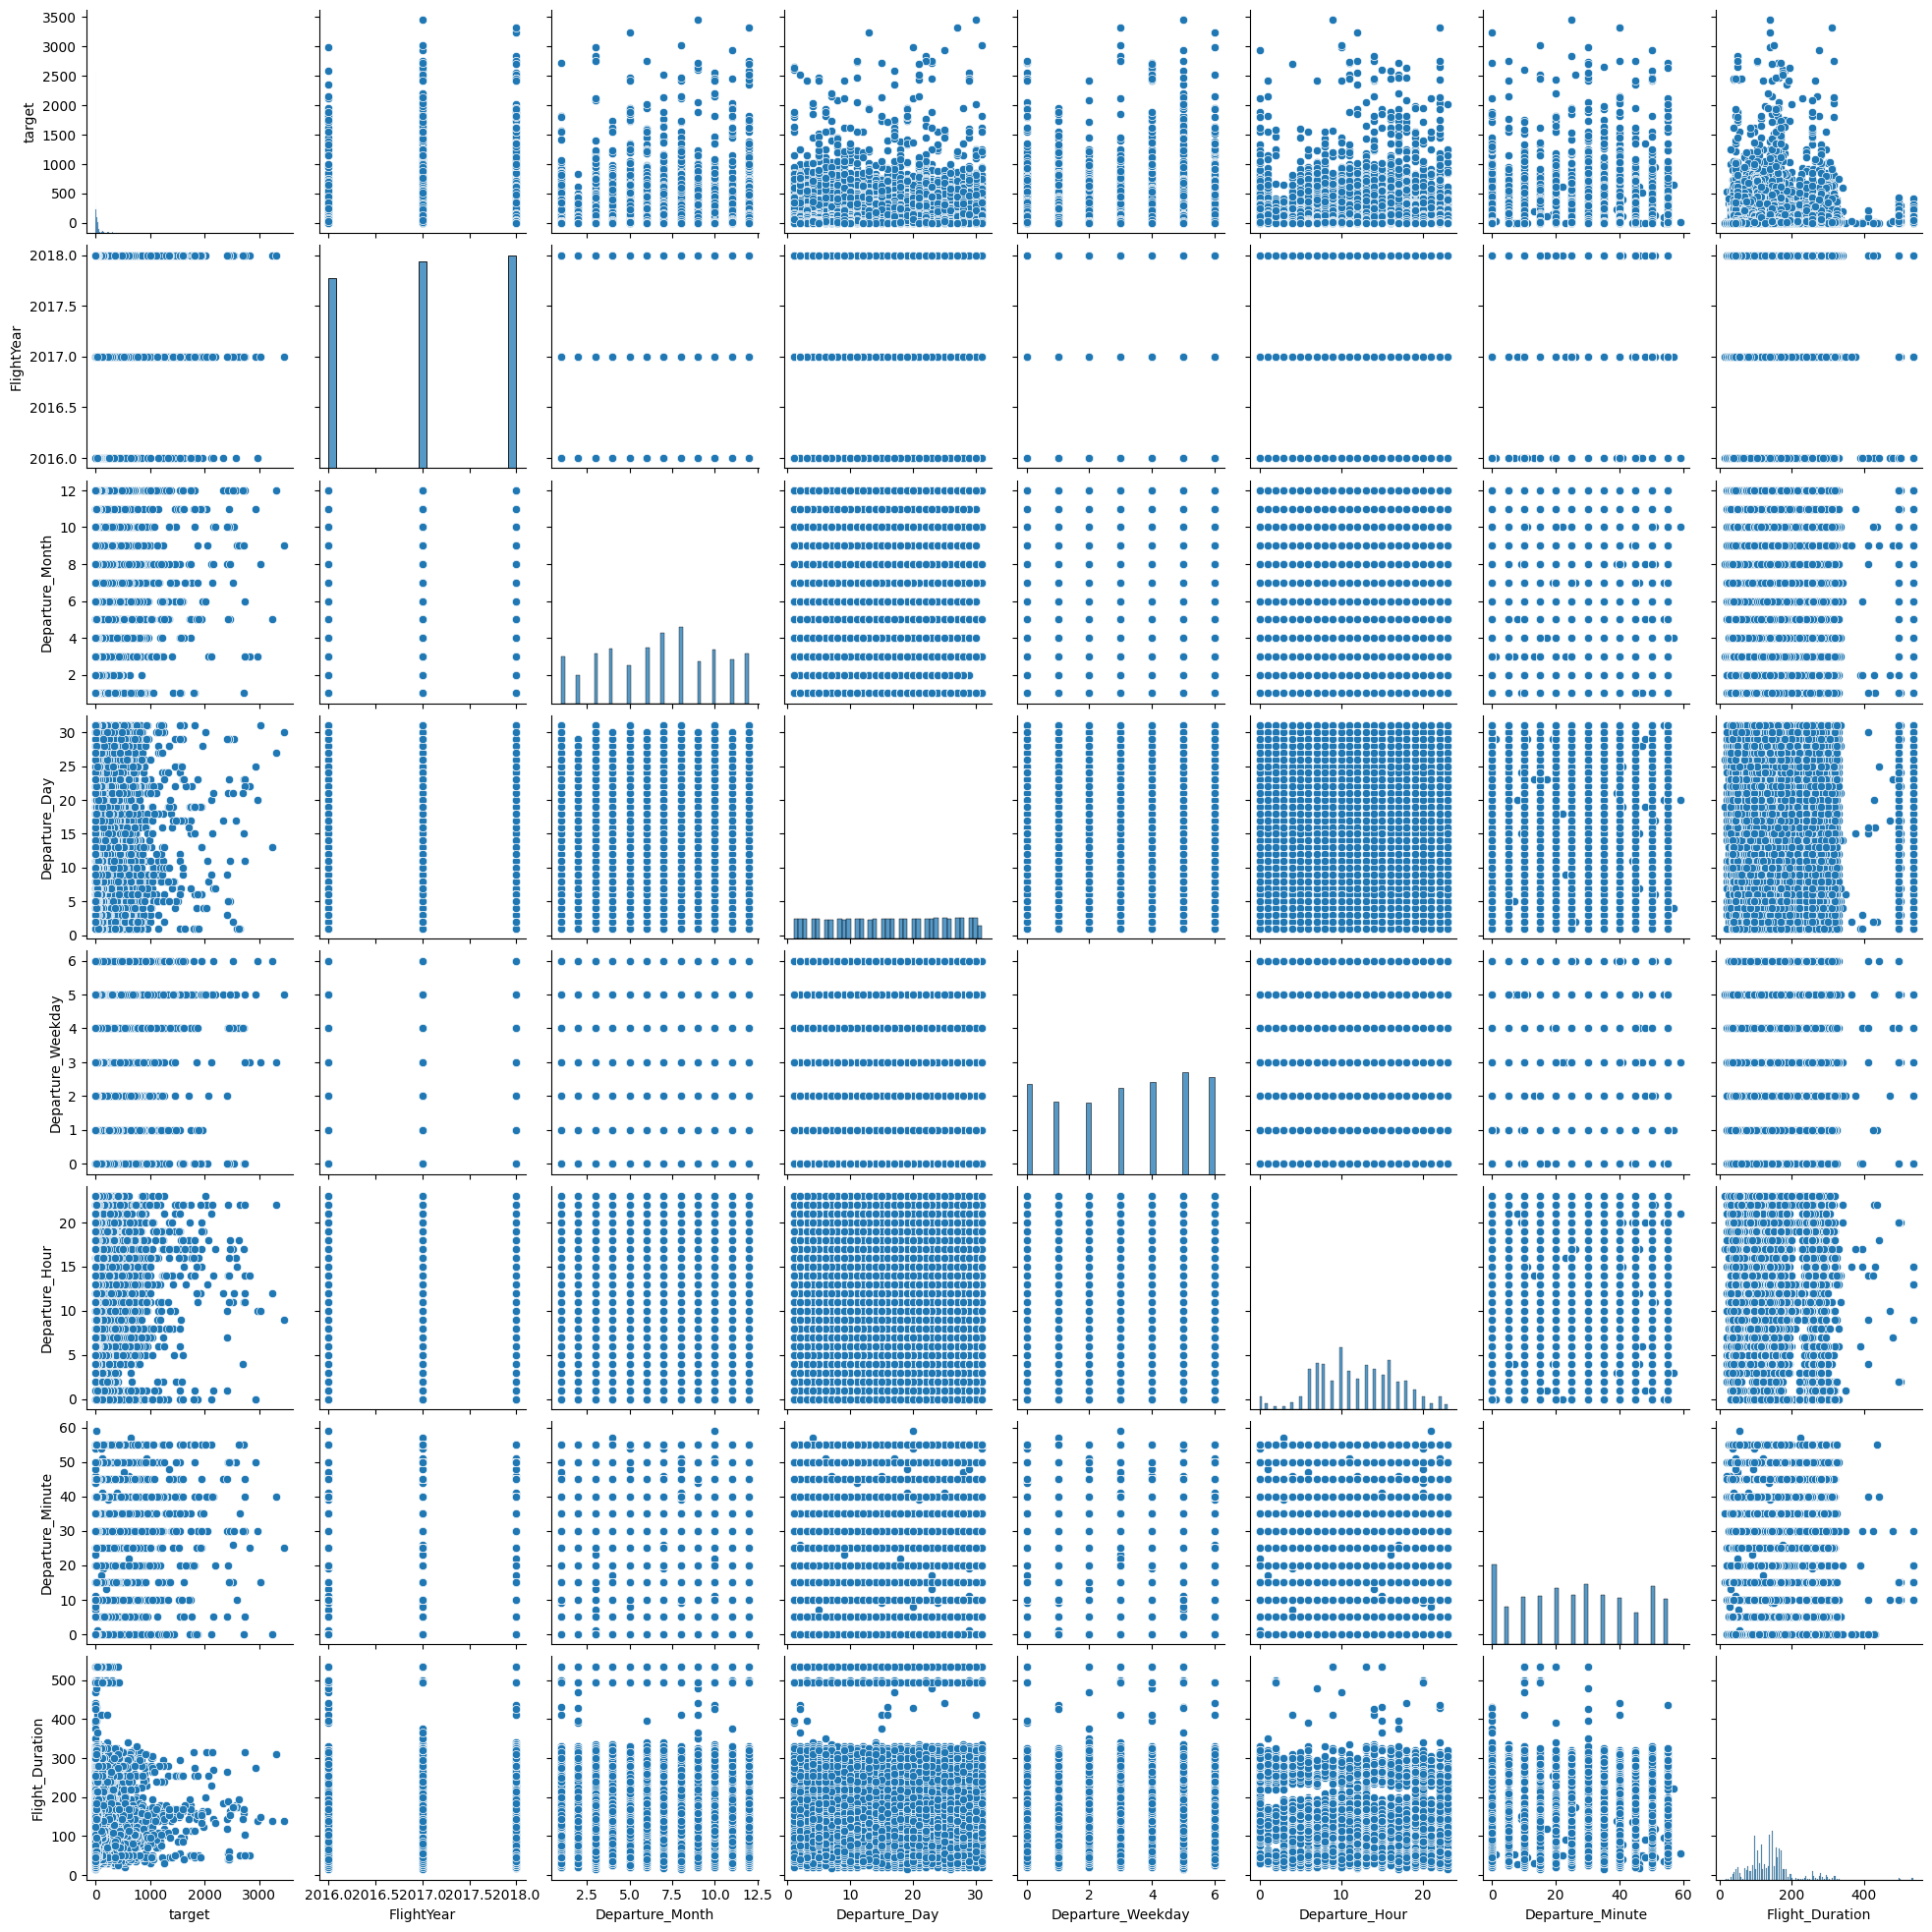

In [121]:
# Pairplot for columns of interest
sns.pairplot(df[interest])
plt.show()

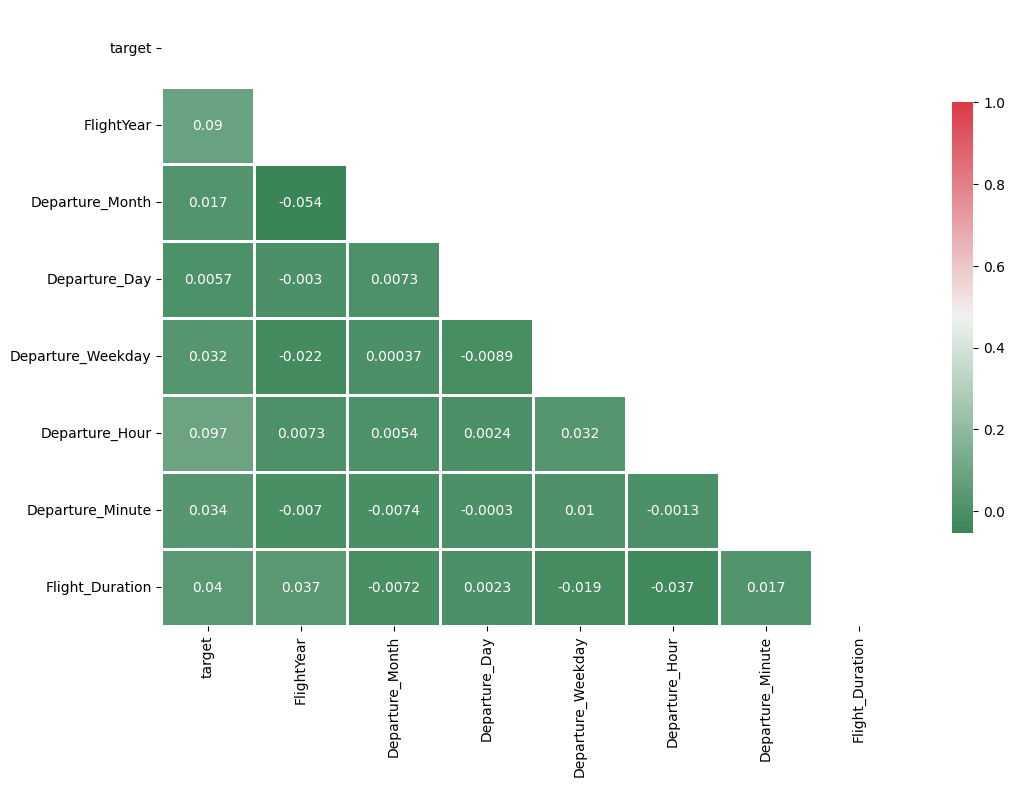

In [122]:
# Correlation heatmap

fig, ax = plt.subplots(figsize=(12,8))

# Create a new DataFrame that only includes the numerical variables
df_numeric = df[interest].select_dtypes(include=['float64', 'int32'])

# Compute correlations
correlations = df_numeric.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(140, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio

sns.heatmap(correlations, mask=mask, cmap=cmap, vmax=1, annot=True,
            linewidths=1, cbar_kws={"shrink": .7}, ax=ax);

IndexError: index 5 is out of bounds for axis 0 with size 5

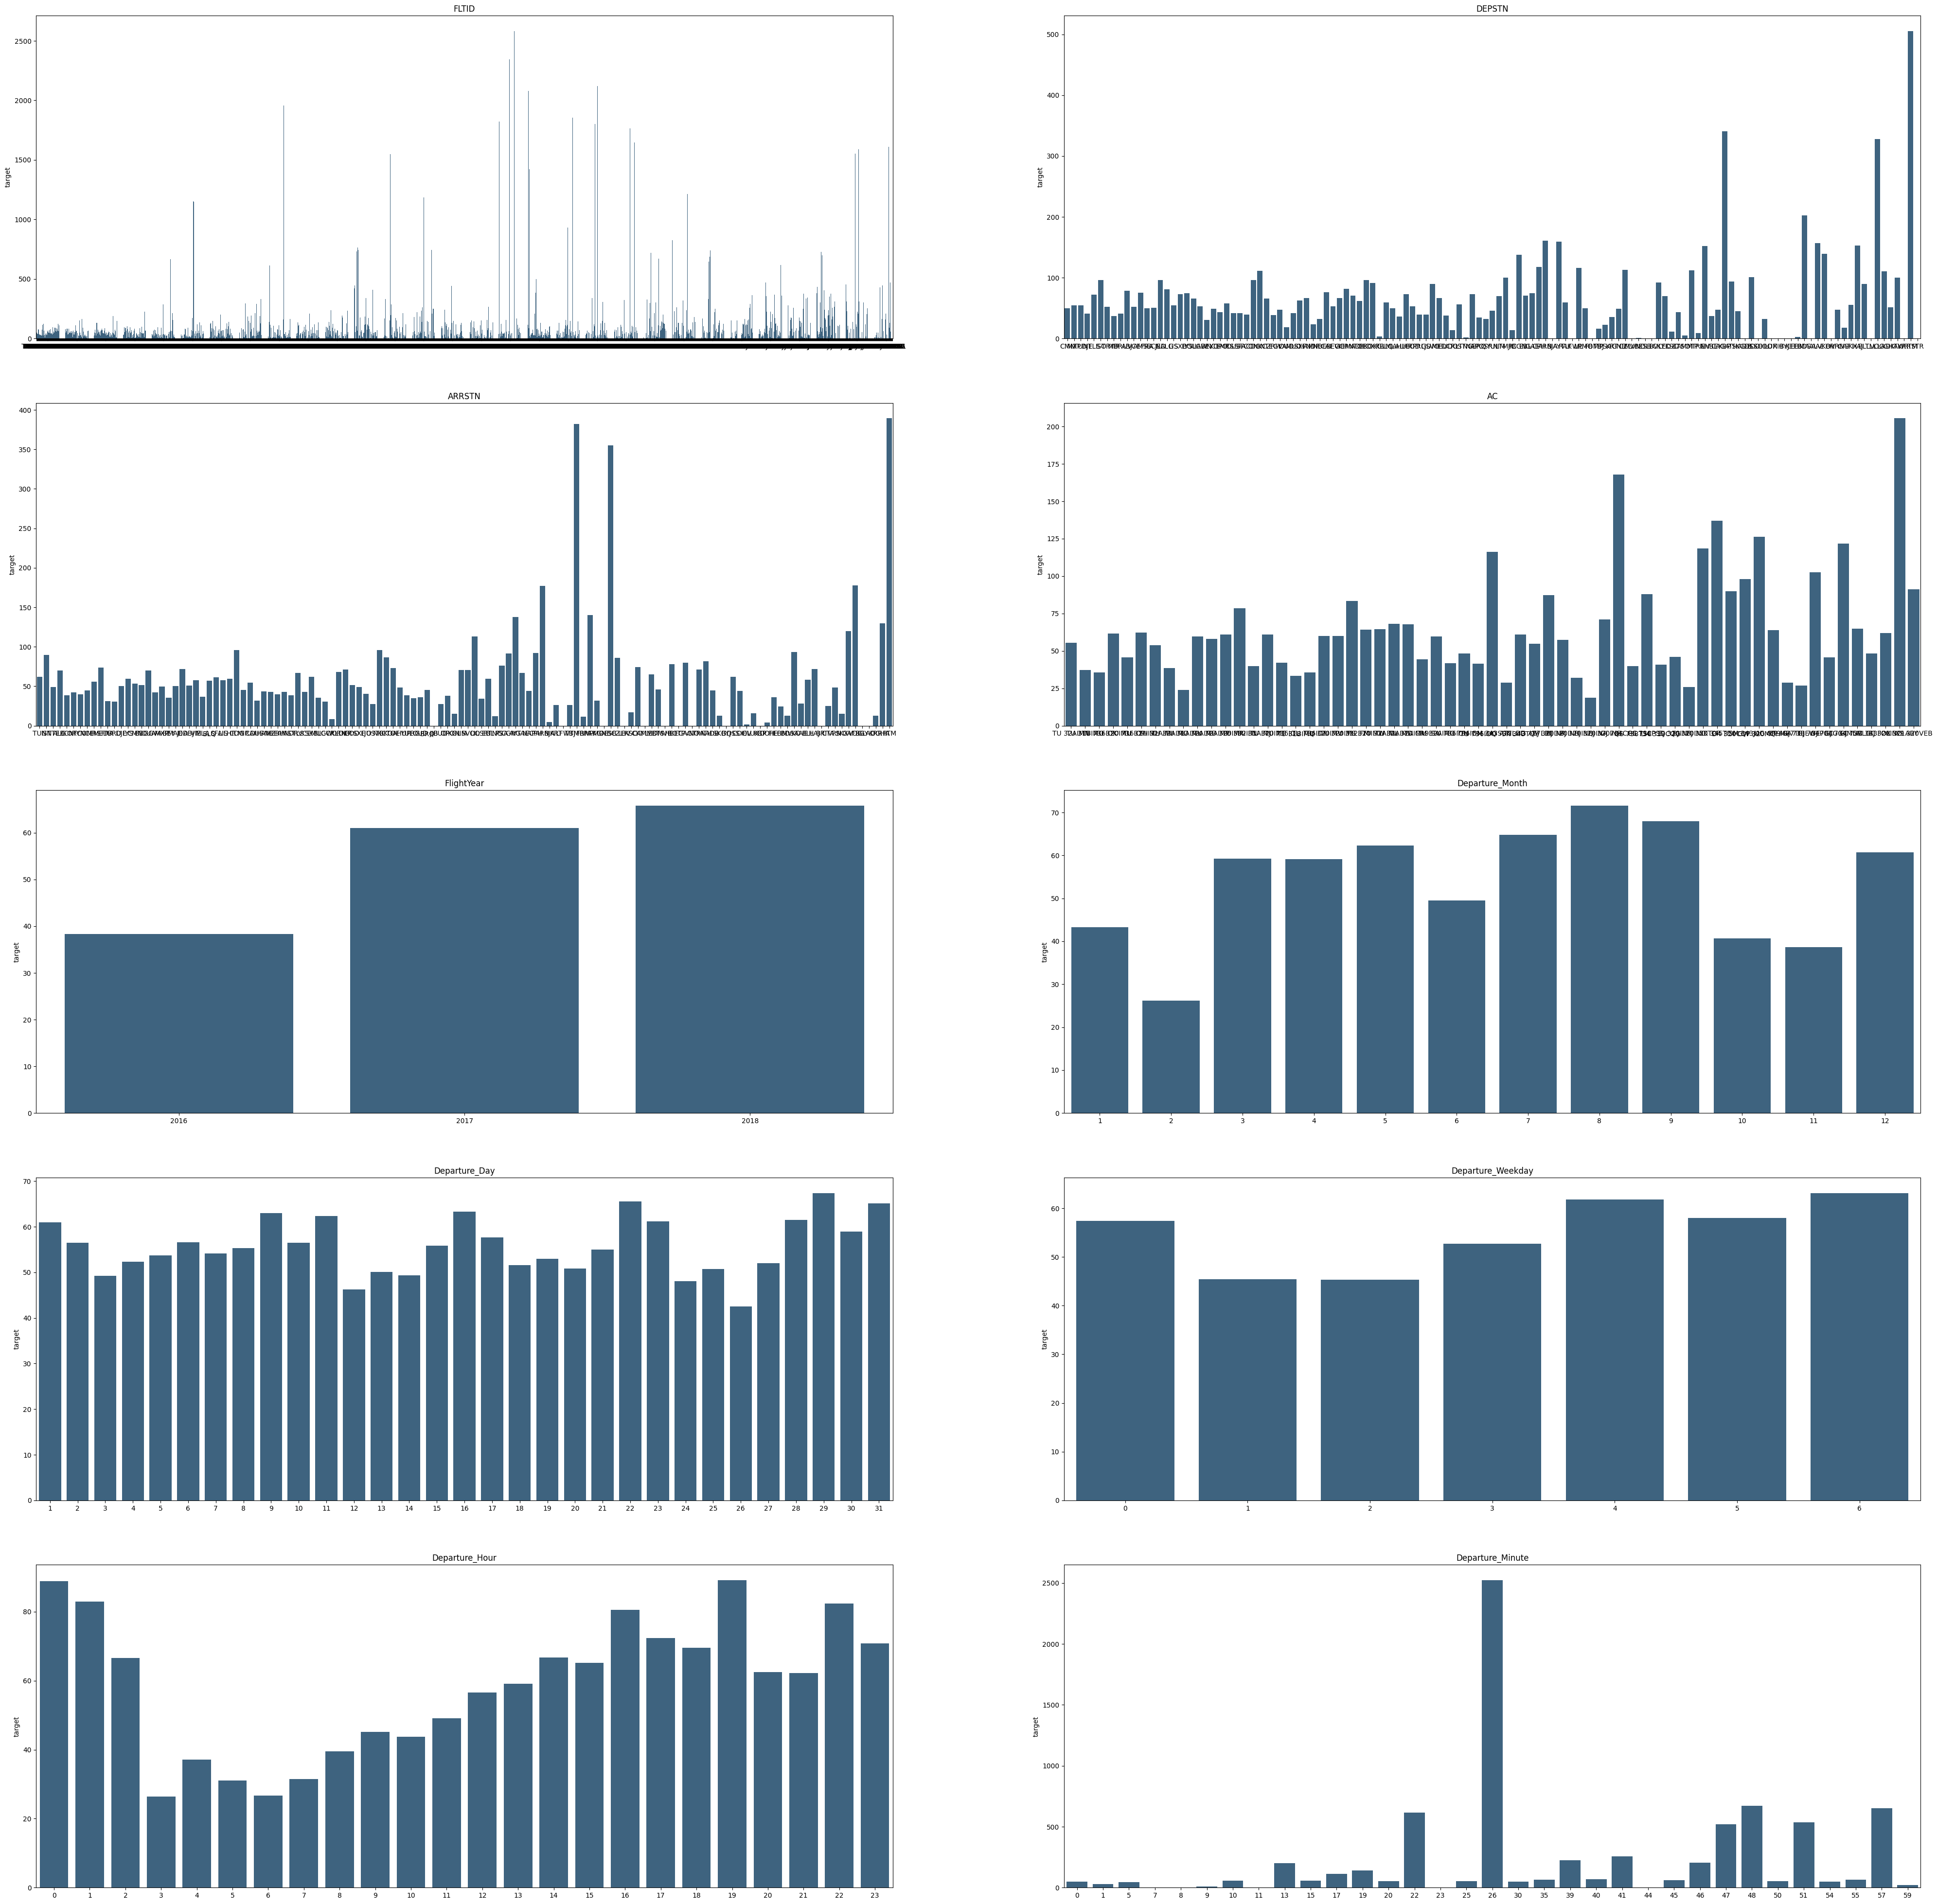

In [123]:
# Barplots
interest_withoutTarget = interest.drop("target")

fig,ax = plt.subplots(5,2,figsize=(50,50))
count = 0
for item in interest_withoutTarget:
    sns.barplot(df, x=df[item], y= df["target"], errorbar=None, ax=ax[int(count/2)][count%2], color='#33658A').set(title=item, xlabel='')
    count += 1
fig.tight_layout(pad=3)

In [124]:
# Check wether flights with high delay only flew once --> yes
# Flights get mean and count of flights
flights = df[["DEPSTN", "ARRSTN", "target"]]
flights = flights.groupby(["DEPSTN", "ARRSTN"]).agg(["mean", "count"]).sort_values(by=("target", "mean"), ascending=False)
flights 

target      
                 mean count
DEPSTN ARRSTN              
LYS    CDG     2456.0     1
TUN    SVO     2123.0     1
ORY    MRS      770.0     1
CAI    DJE      703.0     1
ATH    SFA      653.0     1
...               ...   ...
NCE    TOE        0.0     1
TUN    AMM        0.0     2
DJE    LIL        0.0     1
       IEV        0.0     3
SFA    LYS        0.0     1

[682 rows x 2 columns]

# Train-test split

In [125]:
# Train Test Split
X = df.drop(columns=["target"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Feature Engineering

In [126]:
# Using OneHotEncoder to encode the categorical variables

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')

# Fit and Transform
encoded_X_train = encoder.fit_transform(X_train[['DEPSTN', 'ARRSTN', 'Departure_Month', 'Departure_Weekday', 'Departure_Time_Of_Day']])
encoded_X_test = encoder.transform(X_test[['DEPSTN', 'ARRSTN', 'Departure_Month', 'Departure_Weekday', 'Departure_Time_Of_Day']])


# Convert to DataFrame
encoded_X_train = pd.DataFrame(encoded_X_train, columns=encoder.get_feature_names_out())
encoded_X_test = pd.DataFrame(encoded_X_test, columns=encoder.get_feature_names_out())

# Giving back index to dataframes. This is required because OneHotEncoder returns an arrage, which removes the index
encoded_X_train.index = X_train.index
encoded_X_test.index = X_test.index

# Now add back the flight duration column
encoded_X_train['Flight_Duration']  = X_train['Flight_Duration']
encoded_X_test['Flight_Duration']  = X_test['Flight_Duration']

c:\Users\scorn\Desktop\DataScience&AI\MLProjects\AirorPrediction\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


# Functions to evaluate model

In [127]:
def model_evaluation(train, train_pred, test, test_pred):

    print('Training evaluation metrics: ')
    print('Mean absolute error (MAE): ', mean_absolute_error(train, train_pred))
    print('Mean square error (MSE): ', mean_squared_error(train, train_pred))
    print('Root mean square error (RMSE): ', mean_squared_error(train, train_pred) **0.5)
    print('R2 coefficient of determination: ', r2_score(train, train_pred))
    print('')
    print('---'*5)
    print('Test Evaluation Metrics')
    print('Mean absolute error (MAE): ', mean_absolute_error(test, test_pred))
    print('Mean square error (MSE): ', mean_squared_error(test, test_pred))
    print('Root mean square error (RMSE):', mean_squared_error(test, test_pred) **0.5)
    print('R2 coefficient of determination: ', r2_score(test, test_pred))

# Define baseline model

In [128]:
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)


# Defining baseline model
y_pred_baseline = train_data["target"].mean()

# Make predictions 
test_data["pred_baseline"] = y_pred_baseline


# Evaluate model
from sklearn.metrics import mean_squared_error #measures the variance of the residuals
from sklearn.metrics import r2_score #proportion of the variance in the dependent variable which is explained by the linear regression model

mse = mean_squared_error(test_data["target"], test_data["pred_baseline"])
r2 = r2_score(test_data["target"], test_data["pred_baseline"])
print("MSE:", mse)
print("R2:", r2)


MSE: 14646.298949922631
R2: -1.7188068857088012e-07


# Implement models

In [129]:
# Linear regression model: Simon
lm = LinearRegression()

# Fit model to training data
lm.fit(encoded_X_train, y_train)

# Make predictions on train set
y_train_lm_pred = lm.predict(encoded_X_train)

# Make predictions on test set
y_test_lm_pred = lm.predict(encoded_X_test)

In [ ]:
#Model evaluation
model_evaluation(y_train, y_train_lm_pred, y_test, y_test_lm_pred) 

Training evaluation metrics: 
Mean absolute error (MAE):  58.84625160195647
Mean square error (MSE):  14600.512187979431
Root mean square error (RMSE):  120.832579166297
R2 coefficient of determination:  0.04930713590029423

---------------
Test Evaluation Metrics
Mean absolute error (MAE):  58.69036903074624
Mean square error (MSE):  13947.105267722169
Root mean square error (RMSE): 118.09786309549453
R2 coefficient of determination:  0.047738427800294136


In [26]:
# Random forest with CV (categorical variables need first to be encoded)


RSEED = 99

# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

random_grid = {'n_estimators': [int (x) for x in np.linspace(100, 2000, num=10)], # The number of trees in the forest
               'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'], #function to measure the quality of a split
               'max_depth':  [int (x) for x in np.linspace(1, 200, num=10)], #The maximum depth of the tree
               'min_samples_split': [2, 4, 8, 10], # The minimum number of samples required to split an internal node
               'min_samples_leaf': [1, 2, 3, 4], #The minimum number of samples required to be at a leaf node
               'max_features': ['log2', 'sqrt', None], #The number of features to consider when looking for the best split
               }

model_RF = RandomizedSearchCV(RandomForestRegressor(), param_distributions = random_grid, n_iter = 100, cv = cv, verbose=2, random_state=RSEED, n_jobs = -1)


# Fit on training data
model_RF.fit(encoded_X_train, y_train)


Fitting 30 folds for each of 100 candidates, totalling 3000 fits


c:\Users\scorn\Desktop\DataScience&AI\MLProjects\AirorPrediction\.venv\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\scorn\Desktop\DataScience&AI\MLProjects\AirorPrediction\.venv\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\scorn\Desktop\DataScience&AI\MLProjects\AirorPrediction\.venv\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# Print best parameters
print("Tuned hyperparameters :(best parameters) ",model_RF.best_params_)

In [ ]:
# Evaluate RandomForest model
from sklearn.metrics import mean_squared_error, r2_score

y_pred_train = model_RF.predict(encoded_X_train)
y_pred_test = model_RF.predict(encoded_X_test)

print("Train: mean_squared_error:", mean_squared_error(y_train, y_pred_train).round(3))
print("Train: R-squared:", r2_score(y_train, y_pred_train).round(3))

print("Test: mean_squared_error:", mean_squared_error(y_test, y_pred_test).round(3))
print("Test: R-squared:", r2_score(y_test, y_pred_test).round(3))

In [ ]:
# Boosting model

# Visualization of the results
Partial dependence plots? <br>
Permutation feature importance?